In [1]:
# import pandas as pd
# import numpy as np
# import re
#Importing everything from NLP Week 1 - following that as a guide for now
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
pd.options.display.max_rows = 100
pd.options.display.width = 150
RANDOM_SEED = 696


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
pd.get_option("display.width")

150

In [3]:
WikiLarge_Train_df = pd.read_csv(r'assets/WikiLarge_Train.csv')#, \

In [4]:
# print(WikiLarge_Train_df.tail())
# print(WikiLarge_Train_df['label'].value_counts())

In [5]:
WikiLarge_Train_df['parsed_list'] = 0
WikiLarge_Train_df['All_Characters'] = 0
WikiLarge_Train_df['Is_Int'] = 0
for i, row in WikiLarge_Train_df.iterrows():
        temp = row['original_text']
        WikiLarge_Train_df['parsed_list'].at[i] = re.split(r'(\s)', temp)
        if temp.isalpha():
                WikiLarge_Train_df['All_Characters'].at[i] = 1
        try:
                int(temp)
                WikiLarge_Train_df['Is_Int'].at[i] = 1
        except:
                pass

        #WikiLarge_Train_df['parsed_list'].at[i] = re.split(r'(-|,|\s)\s*', temp)
        # Do we need to be greedy?

# Are commas always split by spaces?

In [6]:
print(WikiLarge_Train_df.head(5))

                                       original_text  label                                        parsed_list  All_Characters  Is_Int
0  There is manuscript evidence that Austen conti...      1  [There,  , is,  , manuscript,  , evidence,  , ...               0       0
1  In a remarkable comparative analysis , Mandaea...      1  [In,  , a,  , remarkable,  , comparative,  , a...               0       0
2  Before Persephone was released to Hermes , who...      1  [Before,  , Persephone,  , was,  , released,  ...               0       0
3  Cogeneration plants are commonly found in dist...      1  [Cogeneration,  , plants,  , are,  , commonly,...               0       0
4  Geneva -LRB- , ; , ; , ; ; -RRB- is the second...      1  [Geneva,  , -LRB-,  , ,,  , ;,  , ,,  , ;,  , ...               0       0


In [7]:
WikiLarge_Train_df['All_Characters'].value_counts()

0    407992
1      8776
Name: All_Characters, dtype: int64

In [8]:
#Not many -so I'm not going to worry about these
print(WikiLarge_Train_df['Is_Int'].value_counts())
print(WikiLarge_Train_df[WikiLarge_Train_df['Is_Int'] ==1 ]['label'].value_counts())
# The following shows there's no rhyme or reason to the way they're flagged
# WikiLarge_Train_df[WikiLarge_Train_df['Is_Int'] ==1 ].head(50)

0    416718
1        50
Name: Is_Int, dtype: int64
0    40
1    10
Name: label, dtype: int64


Okay, lets divide the set into train dev and test just for fun and see about getting started

In [9]:
train_df, dev_df, test_df = np.split(WikiLarge_Train_df.sample(frac=1, random_state= RANDOM_SEED), 
                       [int(.8*len(WikiLarge_Train_df)), int(.9*len(WikiLarge_Train_df))], axis = 0)

In [10]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(333414, 5)
(41677, 5)
(41677, 5)


FROM NLP Week 1:

What tokens should count as a "word" and how do we find them? For this exercise, we'll try extract three kinds of tokens using different methods to see what happens

1. ws_tokens: dict count of tokens separated by whitespace
2. alpha_ws_tokens: dict count of tokens separated by whitespace and are alpha numeric
3. alpha_re_tokens: dict count of tokens separated by word boundaries that only consist of alphanumeric characters

As quick example of how these are different, let's say we have the sentence "My computer says 'I don't know...' but after thinking about it, I think it does."

* The first case should return ['My', 'computer', 'says', "'I", "don't", "know...'", 'but', 'after', 'thinking', 'about', 'it,', 'I', 'think', 'it', 'does.'], which we can see contains a bunch of tokens that have punctuation with them.

* The second case should return ['My', 'computer', 'says', 'but', 'after', 'thinking', 'about', 'I', 'think', 'it'] which is filtering out a lot more tokens. We see that any token with any punctuation gets removed. This is probably too much but the tokens do look cleaner

* The third case should return ['My', 'computer', 'says', 'I', 'don', 't', 'know', 'but', 'after', 'thinking', 'about', 'it', 'I', 'think', 'it', 'does'], which gives us all the tokens. Here we see that it's also split "don't" into two tokens too! We could modify our regex some to allow intra-token punctuation to avoid this but for now we'll keep it a it simple.

In [11]:
ws_tokens = Counter()
alpha_ws_tokens = Counter()
alpha_re_tokens = Counter()
count = 0

for sent in tqdm(train_df.original_text):
#if count > 1:
    alphanumeric_list = []
    alpha_re_list = []
    sentlist = sent.split()

    ws_tokens.update(sentlist)

    for element in sentlist:
        #alphanumeric_regex = re.compile(r'[a-zA-Z0-9]+')
        alphanumeric_regex = re.compile(r'\w+')
        if re.fullmatch(alphanumeric_regex, element) != None:
            alphanumeric_list.append(element)
            #print("element:", element, "\nalpha_ws_list:",alpha_ws_list)

    alpha_re_list = re.findall(alphanumeric_regex, sent)
    alpha_ws_tokens.update(alphanumeric_list)
    alpha_re_tokens.update(alpha_re_list)

100%|████████████████████████████████████████████████████████████████████████| 333414/333414 [00:12<00:00, 25685.50it/s]


In [12]:
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))

180497
150320
155812


In [13]:
top_50 = alpha_re_tokens.most_common(50)
#hidden tests are within this cell
top_50

[('the', 388051),
 ('of', 231298),
 ('in', 184434),
 ('and', 168008),
 ('a', 146692),
 ('is', 130853),
 ('to', 99037),
 ('RRB', 87115),
 ('LRB', 86878),
 ('The', 69017),
 ('was', 65924),
 ('as', 47474),
 ('for', 42317),
 ('by', 42126),
 ('on', 40038),
 ('with', 33040),
 ('s', 30582),
 ('that', 29589),
 ('from', 29501),
 ('are', 27668),
 ('an', 27376),
 ('or', 26066),
 ('It', 23917),
 ('at', 22762),
 ('his', 19793),
 ('which', 18768),
 ('In', 18721),
 ('it', 17895),
 ('also', 16284),
 ('has', 15611),
 ('be', 15144),
 ('he', 14975),
 ('born', 14891),
 ('first', 14506),
 ('were', 13468),
 ('France', 13454),
 ('He', 13349),
 ('one', 12754),
 ('known', 11524),
 ('who', 11262),
 ('United', 11159),
 ('not', 10888),
 ('its', 10738),
 ('department', 10574),
 ('have', 10282),
 ('city', 10253),
 ('A', 10196),
 ('de', 10067),
 ('1', 9896),
 ('commune', 9647)]

155812 0 155811
155812 0.05914372062349407 1.5241223608106686e-07


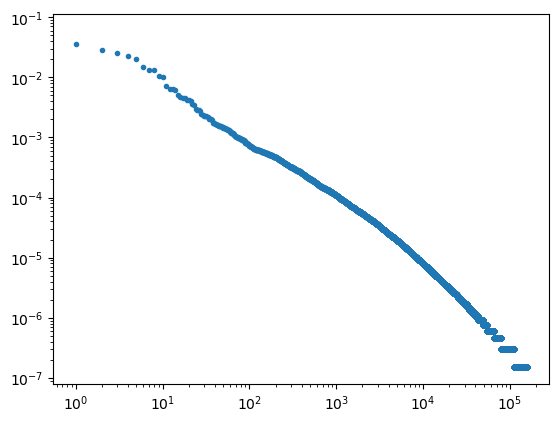

In [14]:
#Plot the word distribution
dict_pairs = dict(alpha_re_tokens)
total_counts = sum(dict_pairs.values())

#sorted_dict = {}
sorted_keys = sorted(dict_pairs, key=dict_pairs.get, reverse=True) 
x = [] #rank
y = [] #probability
count = 0
for w in sorted_keys:
    #print(w, dict_pairs[w], sorted_dict)
    x.append(count)
    y.append(dict_pairs[w] / total_counts)
    count += 1

print(len(x), x[0], x[-1])
print(len(y), y[0], y[-1])

ax = plt.plot(x, y, '.')
plt.yscale('log')
plt.xscale('log')

Convert text to features

In [15]:
vectorizer = TfidfVectorizer(min_df=500, stop_words= 'english')
X_train = vectorizer.fit_transform(train_df.original_text)
print(X_train.shape)

(333414, 1099)


In [16]:
#Make list of labels
y_train = list(train_df.label)

Fit the classifier - using all the data but could narrow this down to save time. Lets just see if it takes a long time

In [17]:
clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=500, multi_class='ovr', solver= 'newton-cholesky')
#clf.fit(X_train[0:10000,:], y_train[0:10000])
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=696,
                   solver='newton-cholesky')

Generate the dev data

In [18]:
X_dev = vectorizer.transform(dev_df.original_text)
y_dev = list(dev_df.label)
type(X_dev)

scipy.sparse._csr.csr_matrix

Create the Dummy Classifiers

In [19]:
uniform_dummy = DummyClassifier(strategy='uniform', random_state = RANDOM_SEED, constant=None)
most_freq_dummy = DummyClassifier(strategy='most_frequent', random_state = RANDOM_SEED, constant=None)

uniform_dummy.fit(X_train, y_train)
most_freq_dummy.fit(X_train, y_train)

DummyClassifier(random_state=696, strategy='most_frequent')

Generate the predictions

In [20]:
lr_tiny_dev_preds = clf.predict(X_dev)
rand_dev_preds = uniform_dummy.predict(X_dev)
mf_dev_preds = most_freq_dummy.predict(X_dev)

Score the predictions

In [21]:
lr_f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')
rand_f1 = f1_score(y_dev, rand_dev_preds, average='macro')
mf_f1 = f1_score(y_dev, mf_dev_preds, average='macro')
print(lr_f1)
print(rand_f1)
print(mf_f1)

0.6421682653633889
0.49840355363816646
0.333061289806369


Create a function for the steps so we can run it for various amounts of data to see the difference

## Matt experiments:

### 1
 TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii' ,stop_words='english', analyzer='char_wb', ngram_range=(1,3))
 
 LogisticRegression(random_state=RANDOM_SEED, max_iter=500, C=.1, multi_class='ovr', solver= 'newton-cg')
 
 [0.5367548454017107, 0.655777640516025, 0.674599129866489, 0.6804460573909678, 0.688381517756455]

### 2
 TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii' ,stop_words='english', analyzer='char_wb', ngram_range=(1,3), lowercase=False)
 
  LogisticRegression(random_state=RANDOM_SEED, max_iter=500, C=.1, multi_class='ovr', solver= 'newton-cg')
 
 [0.5431826182998672, 0.6592851964393285, 0.6770780203143197, 0.682915289861274, 0.6933228754367546]

In [27]:
# Vectorizer
vectorizer = TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii',  analyzer='char_wb', ngram_range=(1,3), lowercase=False)

# Transform data and labels
X_train = vectorizer.fit_transform(train_df.original_text)
y_train = list(train_df.label)

# Pipeline and grid
pipeline = Pipeline([('classifier', LogisticRegression())])

param_grid = [
    {'classifier': [LogisticRegression()],WW
     'classifier__penalty' : ['l2'],
     'classifier__C': np.logspace(0,4,50),
     'classifier__solver': ['newton-cholesky', 'newton-cg'],
    }
]

# Grid setup and train
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=4, pre_dispatch=4)

best_clf = clf.fit(X_train, y_train)

/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: Convergenc

In [32]:
best_clf.best_params_

{'classifier': LogisticRegression(solver='newton-cholesky'),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cholesky'}

In [34]:
def train_and_score(train_df, dev_df):
    # Fit a new TfidfVectorizer
    #vectorizer = TfidfVectorizer(min_df=25, stop_words= 'english')
    vectorizer = TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii',  analyzer='char_wb', ngram_range=(1,3), lowercase=False)
    X_train = vectorizer.fit_transform(train_df.original_text)

    #Get the labels
    y_train = list(train_df.label)

    #Fit the data to a Logistic Regression Classifier (in this example a subset of 10k)
    #clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='auto', solver= 'lbfgs')
    clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=500, C=1, multi_class='ovr', solver= 'newton-cholesky')
    clf.fit(X_train, y_train)

    # Generate the dev data
    X_dev = vectorizer.transform(dev_df.original_text)
    y_dev = list(dev_df.label)

    # Generate the predictions
    lr_tiny_dev_preds = clf.predict(X_dev)

    # Score the predictions
    f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')

    # the function returns the macro-averaged F1 score on the dev data
    return f1

def change_in_performance(training_sizes, train_df, dev_df):
    random.seed(RANDOM_SEED)
    f1_scores = []
    for training_size in tqdm(training_sizes):
        f1_scores.append(train_and_score(train_df.head(training_size), dev_df))
    return(f1_scores)

training_sizes = [1000, 10000, 50000, 100000, 333414]
performace_f1_scores = change_in_performance(training_sizes, train_df, dev_df)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:32<00:00, 66.54s/it]


Used these tips from NLP Week 1 to fine tune:

Overall lots of room for improvement. We could certainly try fine-tuning some of the hyperparameters though! Some useful ideas to try by altering the TF-IDF vectorizer or classifier:
* use lower `min_df` to increase the number of features
* don't use stopword removal
* tune the `C` parameter on the logistic regression classifier
* don't lower-case the text 
* use a `CountVectorizer` instead of a TF-IDF vectorizer
* set `max_df` to remove common features

Which do you think will lead to higher performance? Try some out and report on the Slack or Piazza what's the highest performance you can achieve!

[0.6183723953111302, 0.6673916826003882, 0.6818282649034958, 0.6877756360255619, 0.6962710421128029]


<AxesSubplot: xlabel='num_instances', ylabel='f1'>

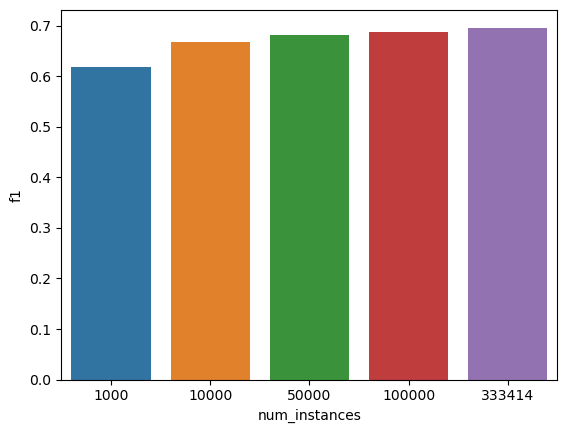

In [35]:
print(performace_f1_scores)

df = pd.DataFrame({'num_instances': training_sizes, 'f1': performace_f1_scores})
sns.barplot(data=df, x='num_instances', y='f1')

Try a uni, bi, and trigram vectorizer

In [27]:
trigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=25, ngram_range=(1,3))
X_train = trigram_vectorizer.fit_transform(train_df.original_text)
print(X_train.shape)
clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='ovr', solver= 'newton-cg')
clf.fit(X_train, y_train)
#featurize the dev data
X_dev = trigram_vectorizer.transform(dev_df.original_text)
#predict the dev data and score
lr_trigram_dev_preds = clf.predict(X_dev)
lr_f1 = f1_score(y_dev, lr_trigram_dev_preds, average='macro')

(333414, 23797)


In [28]:
print(lr_f1)

0.6879448653584948


min_df @ 500, ngram_range(1,3), multi_class='ovr', solver = 'newton-cholesky' (didn't take too long) scored 0.6451618658
min_df @  25, ngram_range(1,3), multi_class='ovr', solver = 'newton-cholesky' (6m 19.1s) scored 0.6880169450552442

Read in the Dale Chall text - into a list

In [30]:
dc_text = open(r'assets/dale_chall.txt', "r")
dalechall_file = dc_text.read()
# split text on new line
dalechall_list = dalechall_file.split('\n')
print(dalechall_list[0:5])

['a', 'able', 'aboard', 'about', 'above ']


In [31]:
len(dalechall_list)

2950

# Scores

In [18]:
# !pip install spacy
# !pip install spacy_syllables
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !pip install pandarallel

In [22]:
import re
import spacy
from spacy_syllables import SpacySyllables
from pandarallel import pandarallel

In [23]:
# using https://spacy.io/universe/project/spacy_syllables
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("syllables", after="tagger")

pandarallel.initialize(progress_bar=True)    

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [24]:
split_pat = re.compile(r'\b\s+\b')

WikiLarge_Train_df['og_split'] = WikiLarge_Train_df['original_text'].apply(lambda x: re.split(split_pat, x))
WikiLarge_Train_df['total_words'] = WikiLarge_Train_df['og_split'].apply(lambda x: len(x))
WikiLarge_Train_df['long_words'] = WikiLarge_Train_df['og_split'].apply(lambda x: len([y for y in x if len(y) > 7]))
WikiLarge_Train_df['total_sentences'] = 1
WikiLarge_Train_df['total_characters'] = WikiLarge_Train_df['og_split'].apply(lambda x: sum([len(y) for y in x]))

In [49]:
long_pat = re.compile(r'(?x)(([A-Z]\.)+ | \w+(-\w+)* | \$?\d+(\.\d+)?%? | \.\.\. | [\]\[.,;"?\'():-_])')

WikiLarge_Train_df['extract_split'] = WikiLarge_Train_df['original_text'].parallel_apply(lambda x: [''.join(list(y)) for y in re.findall(long_pat, x)])

In [51]:
WikiLarge_Train_df['extract_split'][279]

["'",
 "'",
 'Fallen',
 'Leaves',
 "'",
 "'",
 'is',
 'the',
 'third',
 'single',
 'released',
 'from',
 'the',
 'Canadian',
 'rock',
 'group',
 'Billy',
 'Talent',
 "'",
 's',
 'second',
 'album',
 ',',
 'Billy',
 'Talent',
 'II',
 '.']

In [25]:
# Runs slow
WikiLarge_Train_df['syl_list'] = WikiLarge_Train_df['original_text'].parallel_apply(lambda x: [token._.syllables_count for token in nlp(x)])

In [26]:
WikiLarge_Train_df

,original_text,label,parsed_list,All_Characters,Is_Int,og_split,total_words,long_words,total_sentences,total_characters,syl_list
0,There is manuscript evidence that Austen conti...,1,"[There, , is, , manuscript, , evidence, , ...",0,0,"[There, is, manuscript, evidence, that, Austen...",34,7,1,182,"[1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"In a remarkable comparative analysis , Mandaea...",1,"[In, , a, , remarkable, , comparative, , a...",0,0,"[In, a, remarkable, comparative, analysis , Ma...",19,6,1,136,"[1, 1, 3, 4, 3, None, 2, 2, 1, None, 2, 3, 1, ..."
2,"Before Persephone was released to Hermes , who...",1,"[Before, , Persephone, , was, , released, ...",0,0,"[Before, Persephone, was, released, to, Hermes...",36,10,1,213,"[2, 2, 1, 2, 1, 2, None, 1, 1, 1, 1, 1, 2, 1, ..."
3,Cogeneration plants are commonly found in dist...,1,"[Cogeneration, , plants, , are, , commonly,...",0,0,"[Cogeneration, plants, are, commonly, found, i...",26,11,1,221,"[5, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, None, 3, Non..."
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"[Geneva, , -LRB-, , ,, , ;, , ,, , ;, , ...",0,0,"[Geneva -LRB- , ; , ; , ; ; -RRB- is, the, sec...",18,8,1,184,"[2, None, None, None, None, None, None, None, ..."
...,...,...,...,...,...,...,...,...,...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0,"[A, , Duke, , Nukem, , 3D, , version, , h...",0,0,"[A, Duke, Nukem, 3D, version, has, been, sold,...",14,2,1,66,"[1, 1, 1, None, 2, 1, 1, 1, 1, 1, 1, 1, 3, Non..."
416764,"However , it is becoming replaced as a method ...",0,"[However, , ,, , it, , is, , becoming, , ...",0,0,"[However , it, is, becoming, replaced, as, a, ...",17,6,1,95,"[3, None, 1, 1, 3, 2, 1, 1, 1, 1, 4, 3, 1, 1, ..."
416765,There are hand gestures in both Hindu and Budd...,0,"[There, , are, , hand, , gestures, , in, ...",0,0,"[There, are, hand, gestures, in, both, Hindu, ...",10,3,1,55,"[1, 1, 1, 2, 1, 1, 2, 1, 2, 3, None]"
416766,"If it is necessary to use colors , try to choo...",0,"[If, , it, , is, , necessary, , to, , use...",0,0,"[If, it, is, necessary, to, use, colors , try,...",34,7,1,183,"[1, 1, 1, 3, 1, 1, 2, None, 1, 1, 1, 2, 1, 1, ..."


In [27]:
WikiLarge_Train_df['syl_list'] = WikiLarge_Train_df['syl_list'].apply(lambda x: [y for y in x if y is not None])
WikiLarge_Train_df['total_syllables'] = WikiLarge_Train_df['syl_list'].apply(lambda x: sum(x))
WikiLarge_Train_df['total_polysyllables'] = WikiLarge_Train_df['syl_list'].apply(lambda x: sum([1 for y in x if y>2]))


WikiLarge_Train_df

,original_text,label,parsed_list,All_Characters,Is_Int,og_split,total_words,long_words,total_sentences,total_characters,syl_list,total_syllables,total_polysyllables
0,There is manuscript evidence that Austen conti...,1,"[There, , is, , manuscript, , evidence, , ...",0,0,"[There, is, manuscript, evidence, that, Austen...",34,7,1,182,"[1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, ...",48,5
1,"In a remarkable comparative analysis , Mandaea...",1,"[In, , a, , remarkable, , comparative, , a...",0,0,"[In, a, remarkable, comparative, analysis , Ma...",19,6,1,136,"[1, 1, 3, 4, 3, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, ...",37,5
2,"Before Persephone was released to Hermes , who...",1,"[Before, , Persephone, , was, , released, ...",0,0,"[Before, Persephone, was, released, to, Hermes...",36,10,1,213,"[2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...",56,4
3,Cogeneration plants are commonly found in dist...,1,"[Cogeneration, , plants, , are, , commonly,...",0,0,"[Cogeneration, plants, are, commonly, found, i...",26,11,1,221,"[5, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, 3, 2, 1, 3, ...",57,6
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"[Geneva, , -LRB-, , ,, , ;, , ,, , ;, , ...",0,0,"[Geneva -LRB- , ; , ; , ; ; -RRB- is, the, sec...",18,8,1,184,"[2, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, ...",36,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0,"[A, , Duke, , Nukem, , 3D, , version, , h...",0,0,"[A, Duke, Nukem, 3D, version, has, been, sold,...",14,2,1,66,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3]",15,1
416764,"However , it is becoming replaced as a method ...",0,"[However, , ,, , it, , is, , becoming, , ...",0,0,"[However , it, is, becoming, replaced, as, a, ...",17,6,1,95,"[3, 1, 1, 3, 2, 1, 1, 1, 1, 4, 3, 1, 1, 2, 1, ...",31,5
416765,There are hand gestures in both Hindu and Budd...,0,"[There, , are, , hand, , gestures, , in, ...",0,0,"[There, are, hand, gestures, in, both, Hindu, ...",10,3,1,55,"[1, 1, 1, 2, 1, 1, 2, 1, 2, 3]",15,1
416766,"If it is necessary to use colors , try to choo...",0,"[If, , it, , is, , necessary, , to, , use...",0,0,"[If, it, is, necessary, to, use, colors , try,...",34,7,1,183,"[1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, ...",53,3


In [28]:
WikiLarge_Train_df['total_unique_words'] = WikiLarge_Train_df['og_split'].apply(lambda x: len(set(x)))

In [29]:
base_calculated = ['total_words', 'long_words', 'total_sentences', 'total_characters', 'syl_list', 'total_syllables', 'total_polysyllables', 'total_unique_words']

In [30]:
WikiLarge_Train_df[base_calculated].to_csv('assets/base_calculations.csv')

In [31]:
WikiLarge_Train_df['og_split'].to_csv('assets/bsb_token_split.csv')

In [32]:
# !ls -lha assets

In [33]:
# esitmates the years of formal education a person needs to understand the tet on first reading.
WikiLarge_Train_df['gfi'] = 0.4 * (WikiLarge_Train_df['total_words'] + 100 * WikiLarge_Train_df['long_words'])
WikiLarge_Train_df['gfi']

0         293.6
1         247.6
2         414.4
3         450.4
4         327.2
          ...  
416763     85.6
416764    246.8
416765    124.0
416766    293.6
416767     40.8
Name: gfi, Length: 416768, dtype: float64

In [34]:
# FRE ( Flesch reading ease) assigns higher values to more readable texts.
WikiLarge_Train_df['fre'] = 206.835 - 1.015*(WikiLarge_Train_df['total_words']) - 84.6 * (WikiLarge_Train_df['total_syllables']/WikiLarge_Train_df['total_words'])
WikiLarge_Train_df['fre']

0          52.889706
1          22.802632
2          38.695000
3          -5.024231
4          19.365000
             ...    
416763    101.982143
416764     35.309412
416765     69.785000
416766     40.448529
416767     -6.695000
Name: fre, Length: 416768, dtype: float64

In [35]:
# (FKGL) Flesch-Kincaid grade level is the number of years of education generally required to understand the text for which the formula was calculated
WikiLarge_Train_df['fkgl'] = 0.39 * (WikiLarge_Train_df['total_words']) + 11.8 * (WikiLarge_Train_df['total_syllables']/WikiLarge_Train_df['total_words']) - 15.59
WikiLarge_Train_df['fkgl']

0         14.328824
1         14.798947
2         16.805556
3         20.419231
4         15.030000
            ...    
416763     2.512857
416764    12.557647
416765     6.010000
416766    16.064118
416767    14.690000
Name: fkgl, Length: 416768, dtype: float64

In [36]:
# ARI (Automated readability index) years of education required to understand the text
WikiLarge_Train_df['ari'] = 4.71 * (WikiLarge_Train_df['total_characters'] / WikiLarge_Train_df['total_words']) + 0.5 * (WikiLarge_Train_df['total_words']) - 21.43
WikiLarge_Train_df['ari']

0         20.782353
1         21.783684
2         24.437500
3         31.605000
4         35.716667
            ...    
416763     7.774286
416764    13.390588
416765     9.475000
416766    20.920882
416767    24.315000
Name: ari, Length: 416768, dtype: float64

In [37]:
# SMOG (simple measurement of Gobbledygook) roughly corresponds to the number of years of education needed to understand the text
WikiLarge_Train_df['smog'] = 1.0430 * np.sqrt(WikiLarge_Train_df['total_polysyllables'] * 30) + 3.1291
WikiLarge_Train_df['smog']

0         15.903189
1         15.903189
2         14.554593
3         17.122413
4         11.208143
            ...    
416763     8.841846
416764    15.903189
416765     8.841846
416766    13.023867
416767     8.841846
Name: smog, Length: 416768, dtype: float64

In [38]:
# TTR (Type Token Ratio) (number of unique words / number of words)
WikiLarge_Train_df['ttr'] = WikiLarge_Train_df['total_unique_words'] / WikiLarge_Train_df['total_words']
WikiLarge_Train_df['ttr']

# RTTR (root type token ratio)
WikiLarge_Train_df['ttr'] = WikiLarge_Train_df['total_unique_words'] / np.sqrt(WikiLarge_Train_df['total_words'])

# CTTR (corrected type token ratio)
WikiLarge_Train_df['ttr'] = WikiLarge_Train_df['total_unique_words'] / np.sqrt(2 * WikiLarge_Train_df['total_words'])

In [ ]:
# MSTTR is the average TTR for each non-overlapping segment of equal size
segment_size = 5

def msttr_helper(lst:list, segment_size:int=segment_size):
    # segment_size = np.min(segment_size, len(lst))
    print(len(lst))
    lst = [x.lower() for x in lst]
    segments = [lst[i*segment_size: i*segment_size + segment_size] for i in range(int(np.ceil(len(lst)/segment_size)))]
    segment_ttr_vals = [len(set(x)) / segment_size for x in segments if len(x) == segment_size]
    
    return np.sum(segment_ttr_vals)/len(segment_ttr_vals)

    
# WikiLarge_Train_df['msttr'] = WikiLarge_Train_df['og_split'].apply(msttr_helper)
WikiLarge_Train_df['og_split'].parallel_apply(msttr_helper)

32
815

34
2039
2719

1324
2414
36

16
107


201810
2226



40

36
111881898




5
19
299161918




2011183320


23
172126

19

212813



15
38
22102418


39
813
18
1826



13
3476

2030

4120

2525
22



26301713


111


4
12173744
35

26

27
111115

35
26

23142110




15
39

7305272312



4
22

112525

1023
115



1215

26
8

26
13172
291718

31


3
1811318

1
14917





17
4124121155

20

17
27

2018
4

11
235


1123


27
419
102



11188

11
1825
18611
10
17
35


13
29
119

13

21
8
2296


16205
25

19

103330
16
12172
13

25



111411
1418


22


17514
43189

17


1


381520415





221861915
13
1


1125

221414516



21
30

92111

17

3
4614
13
20

25112
23

17291


1427

14331212


2020



37
332328
8
203115



32
11

50
28
281936
15
10

8
224
2
16

17274




171101111246




76
20

6

135
15
4810



1441


15
2011915
31125


28
2212

168613


8

2028

17
6
1031

23
23
14


2510211527
36
18





331213

1228
717
46



1
292421

32426

1441013




1011

419
4

16

2011
23434
7



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



27

8
14
2514
15
13
142

2417
14

16
2721

15

1611

352114
2012


2226


20
24
15

22172


38
9
13
2820118

2516



829
160

2010
226




2528
914316


16262437




15

291210

172
21
8

13301




119
312
311


2914104830


17


2
1742
239
15

28
1118
9

9
169
10
312127
12





181419


1516
216
10
2122166
21





153416

22

16

2422
151392818
26





21
3428161314
18
18

1621


372

13

12
13
35
10
512010
1211419


21



231912
1614

25
11

11
1422

4711

1516
6
13

81715
29
8

24



317459

41
1
281931

1511


30
24
27
23
13
15
10
16

1524
2237
226



12
18
625815





191414
252923928


11
4013


2413

1
167
36


15
31265




41617
3786




3718
15
19121112



19
171923

2
27

132

13
7826




1122011


19
2171620
15

1
1725
24

15
20

27

1416

15
22
729197
7


11

1815
10211511




12
25154410
21




269361025



13
1925

17161
10
4


10

114016
35124




17
132819122013





23
81630
4912
213

14

32



16132313259
4





191124
28
23
2316
18
27189
9




12412
1211
20
18



142

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)





35
8

16

13

14
3

2212

1719
18
16
21

2815
1011

102
127


21515
152030


1814


2822


8

16131617
1518

16

161219
10



231232923



5

152
6
46314


2014

1010
17

181020

31
1
11
222011
13


9

292632



32261713
16
9
17
4



26
1319

2127
213
16
31
123912

4
2313


6
1910
4





1219131838
14269



1

4536223012





5
10
3324571515



13

2030

2019212214





1225
2612209
12

9
19

17

69
1323
12
1820
20

3

3425


2511517
1627



21524

2422


16

1933514


13

51
10
1124286

9

21


10
122
3225241419





22
162120
14114


16

1315
925
18

1711

14

26
1515


2822
27
21
2922


10241214



618

21122

27

22361512
2
12



1127


101229162
17
10

2312



1019
10939
20
23
1

1


92
14238
13

7



9292119

3615
8
22
1626
16
23
1025




18
2323

151

2722
619

30319




14
262617174112



15


16
911


1191312
162619





2320422311214




111733
2


6
52125
33


16
928
87
2016




1430
18251118
32


63134


141828




828253734111






15141118

16

1611

12
1320171699






IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1618918

16

252521

33

15

19

32818

9201418
1618



20
4115
20
1942



1

72221147
8




161718

2714
23
14

40
315
1514
10

1616

20
194
34
16
2552
25



23849

14

21

25

31
1317191513



5
1434

110



17102047614



8


1411
21

4211811
231


34
1891726


22
29

216

221225
10
25


9

311
23

713269

31
1820



7
3
17
119
39233
11
2


1934




33122637241115



1922


217

115

14
22
104310
21
16


44


155112219





48322110
3128
13


47

1322118

17




525431131924
42



47


391044
16
17414

2424

15

1472
14


341
281837
15
9



19
14
19


21927
1618
24

328


25
131121
13
28


10
11

30162112


151910

1018

15
16
22

822929

25


7138314

1


11
171412
3
21
12


3110
1
1811818






1344
1668

8

23
2936
11
13336

16
1222

189
20


9


18
26162
27

232
128
3320


1210
18

21
1115
18

2034



6209
27
2213


126
79
19



131316405
27

19


199


410
82417

4113
16


3
27
131812


139


181161316228






1213191820





3251417
17
10924

9

14
132422
10


345
27


192321

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2422
92822

21
24285


1118



18
279
331412
8



2
201428910
3228


1014




10221921
26
10
2

1510
10
101



8
71214
7
13
1110

19
1931

42

2314

16
68
10

1619

9

529
1726

10

16119


1712


19231920

1


2179

9
1623
33




1192410141818


4
20

118


19
22472128




37
13141012
1514


26


94431



15
1924
13
118
1311
18


342122




191413149

3515

2810



19
936

2312
13
2

13123312




3072621



191417
1318




16
1012
2415

1438

161010
162216


8

101
1718




2919634
823

25

13

281142118

16



716

33
33
8131421

16
13

23
19
9198


926
5
1116
15



12
191
6
7
8

25


131542120332463



27

30
185

481928




1624424115
19





43106331616


23
8
4


23

25118


14578
10

815
915


4715
12


211719
137



169
1212
21
34

26

8

31
26
37
18

1
8
141619
14512
28
219

16
17



8191326
14
16
15


23217

39
1823


13

16
17
213123
12245


10

32
2215
27


1122516

1727


6
7
264


10
17

14
730202020



2416
10159



141343
22
15




1916132125
141242

14


617


96
66

1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)





2610
14



28

251114


10
11
18912
3215
9



2032524

22

191311
1920

1111
21
2



171723
1923


20
21
17
16
2922

15
1212
41
19
16
332417



20

12525
11

16

1592224


5

31
191543
13
13



1414142



18
792017

36

1735


91123


12301157

17

11


47
121615
34

151127


46
2223
3054
16

37


102838
22

20
1
151612426



416
37197


810




39
13101148126



12

19
14
15141611

2410


12

1012

2715423

6


151871626


14


1110

22

2471713
5
9
12
11
23

12

1935
129

2515

126



161115
213212
23

12


42

262272014
21


31
30


30
123418323435

6



501310

815835

29




21419917

4




23219
1911138

1

21
23161



291725141316


16


13


1128
28
111
1514




33171510



24482614



410
172616
17

18
13

6
1844
30
13


23
10612429



25
1813

8

1836



141637
6222
8



2920
84923122
14

16

15


1381
26336
21




21

1
221927
11613
1219




16
24
16239

197
133

29


18

15
1019
301115
20

1483


18
318


321415161738



21
9



28
612
1162512


24
141036
5


13


10
1015

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



182416
22



2018
182119

15


91023

18
34
22
262527
24
720


12



3255291613


20
19
25
2439321


166



41191413
24



9312013




17111322
931


25

1731
13227



9
927214
4


2145

3325

3753
17
1318




23298

10
10
33
24


2614361934
16



2331
925
16

13

26

271416
15

1319161613431




10
2331
149239





7
15
15
1914

625918


31631


19

1225
1

3057
2532
26126




14206
2030


3411
13

8
161431
1030




24
7121111
26



4

37288121
15

38
3
7

281310


42214
15



629
6

41
10

416111714



1319211



13

5294912181416






16541781717





142318
1111

13525


19101310
25




2435171021
14




10
2025207

18



4018
916
20

2011417


6
251127


820

211010



15
16171631
36


102116

26

23
27

526
12
12131317



16

34
24826
168




9815
331313

3

16

23
131310

3320
1632

9
12



2
151627152
2
20




9
811282540




2322
185
32
187


4
11
1721
10
211720

15

24
141

33101121

14


2617

1115
258

23


310
144

47
26


261178
37
25
20

113223


22
3821

1529

6
1
1623

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6
2123

1012
23

812
1517

203410



8

22
12115159


1514


18
2112
2843


13
15

71
9
14
825
13914






2117225231310





171942261629



35



117





33
14827
12
15

171319
1


28727

21
638
10
17
1318



1019
11

1017

71230


22
20317

1


4226
42
30231623


243
12

115



111617641

9





3138248113024


3

5
18
134

461
10


18121234




191510
1223
3514




166
2810
2123

14
9
1220

30162534






251818192217

11
7
27922
34



7

249
13
2422

910



64918489
9

20

19

2111
328
21



16
21396
15
27

1416
7

451814

1011

2059
32
19
1923


20


1711
40
20177
12


24
215

25195



3810
1212
48
181111



26


1058
1723
24716



24



209111
34
4
21159


9
1


143316516

8
12

37

4
15
1
1418267


2
3
25


5120128

2315
13
3
371623
26




112471432
16




581519

416


13

32209



102829

99

15
1619
15
31
720



23
51714101615


16227



18
8
20
9

28172218



21


1216231122
11



16
8
4
69

518
161
9

49
24203227

4


9

22
231216
112328



45

2612411
25




2
1211268101

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



25


926


2619
102717
32
32


3010



187
126

1
31

9
212

911

5311
193




161719
2329
1


26
16
241


3320
13
9

37
44307
21
519



21
21
29712
17
25


311

61716
21

10

1520


313765


111

411


310
201610

10
831
308
2
15




1
1061
13
23
2434

206
10
15
24
20
22

8

2517
1916
2218


7
2128


7141619




5
11
221324
28
26


7193014



196

63010

202113


824
33
1816189



22


151621
19
312

2028138
14




181222261412



16
2114
1015

8
15


22

731613
26
1439

49


108
20

2320
1124


8

1316
17

1121
32

17
25

171814
103
18

151616



134

1991921



2712
88
16
25

4
2927
31014



1430


12
1
31
36242915
9



1268
8
7
31

191911



17

51141017191


26
14

13
7

11351818
23


18

27
17
1127
156

1
11




1917231334
13111


28



92321910
12

38




1517
294426111820
12



2220101114








31895111936
1314



2223
268

30



91121710
2629

19

19


16
313
4
175810

10



21
2612
2211



12131023

23
81518
10


102420
5



14
9
29238
10


16

30
121813
7
33

2032415


282

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



19
27
617
16


20

532
2798
13

2118

181523




919251019
19

19


29
1266
21
11
1



14
1421159191712

19



22

4337
20295
1021


9

231011





16151416720

25



31
33224
152919

14


24
321228
14



2
19529

1811

8

20

18

337
1121718

3056




4
101814162

1013


28246

11



20
2411
2
131647



19
3615619

23

10

2913

15
6101921

18

23
17

151942112





20361317
25
31
5
16
36
29
2312
1
16


21
251912
2430




142
3337
15

1111


132524121915




1313
19
7
16




15162317172518

25
1510214





20623
1613
3814



53
22
14
8
29


86
7112220127






28
5132662014

26




26171623
14
12



2629
20
830

172318





831015181718
6


2


614
16

1723
32
13184


23



271788101
11
9
20

16
1910
13



11

171611914179







1228201630928

14




212319

17362626


22


171322
1034

1329



458

141716

1213

2220


141342113

1



22
161416
913

13



1511232122

12
3726
39
9
21

24
22
11
20
2344
25

17


26
1013712
1325




116

342317117





1642016
142314





1614

4
217231

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



21
12
1115


8
192115



11
5
19
2638
11

15
30
28161235

161535



16171324138







1715213172


71816


25
324
24
266
17
10

29231



31


15
917193717
615

22



16

13814606


201712
22
6




162438293




18211516
321
1815


6


232318


27
8

5
38
2227
26843


2
17
13

2017

392116
3121
10
3




10611120




2114
124413
14

108

31

14

8142214


5599
913
21
26


9

122110
37
19

30
1633
4


82218

728


1624
7
2526
10
25

11
68




7222411711


12

814

16

2821

10
8
1811
10

9

14
14
23222810
17
29



2320
2245
23

1423
24

17
12
189

2715
20


221514



221640241416
9



16118
158
22


36
13
201

12191513


10


9
12
318

893
30

2018
16311





4412

3152417




171021221428


11


5217121



1312014





28121224
202612


167
2010
40
9



18239

19

1124

3

2411
63


2024

20176

1716
37
14
10
13
1621

2934
5
9
10

17
97
13
1525
18




6124212
10

15
20

1513
16
32


18229
1928



15
16121725
17
14
13

3041

3103




14

161
285015925


20



10
371522172

15



2932
311

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)





820271
1412



1127

21
228820


2112

11
20
419
164



372014191615




819

91515

19

12

19
25149

34



87
816
182
23


122113


62226

875
10
28



5926
14
1361014




10

10
7186


22
319107

26


2912

81089




3612141012
26


33
18


812193820
12




251215

19

11
3
12141152415


91317
29






2212139
1031301






91216

11
11221311
3117
20




182513


202613
2516


3517


13114
116
17


1
301121



148318
42257



28
25

221010
102611
29
26




15
2116837322710







111721618
17
21
21

11
12
625


14201010

10



152093
10
1




15412203324


16

23
20319
11

1413
28

354

24
1814
24

13
17
24


30512

213
123739
19

4

50

171253

3482119





16141118


2212
20


446159
1122





141016
2325144
25





23817239
1




591111215419



81

3141125


2279

15






6141841
2423
24

523
11
388

13

1824

21

191011

2018
12
15


2536
2722

14
19


1518

9

3515
26211234
19
1
17


12

634
15179


718
1615

19

4
22

24
222322713

19



832
9
19

9

18331322
58
8

16
1217

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



151017
31
21

18
1311

22111032

8



21
81535
14

22
28
173126


1829
6
2516



213811

10

1


241582681826






6150
4175



2116

18
27
201731


2819

1214
2130
11

28133026

19




19
18
236
2216
18
151


21

15
112212



18271221033





29242071014

9
16


2122
8

161314
9


113
2113

2618

4
1441


2523
2
8111128

16

282730
12
15

12


13
540119

19

18
33

17
1031924
18


2614
2
25
22

24
171711
16


19

819
30
19
27
23


416
916
261

28


31
231410
2
19
12
16
3018
2


620
6619
1825
2




19831

11
1032
30
1016
9
2033


713



321415815
3213

8


420
149

11



241429
33427



26
10
5
22391622
26



1112

32292
5
28


17
17
51014
18

202252
31

20189

25


20


1325101269

178



17
11231442

7



21203


2911215

23
139

626


18
20
1031
419


1517

112

17

16

1
31812
241712

16

171143

1426

911
23
13

7
4


8
1616
25
2713

259
23


1824
1322
13
619

9

34
1016
347



151
13
914


13325613
14
1914



2212



1127
1720

1732
19
31322011







12
303219
232

2524127



2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




18
40221314
10

2617

151411

20


1635179






141714252015
29
19


38371
14
12

616
1

12



916101



1617
33121715


4720


151613

1932

21

236
12

2113

3111
15
3
13
12

8
411910

18
914

914


1731313
23

10
5


17
3289
24
209


229
87

15
3018
20
14



2
1213241117
11



1718
12
17
11393254




571015


5297





222133
82735
7


16

17
24193215
33

18



28612
5271228


32


14

121918
48

1421
30

10


1415221121


1519



1561020
413018


2315



4

2723
13

124118
11
7
1418

18




1418321310
20
18


1012
2331
6

121111

31
22
12
18
33


33
161032
121821



616
27

118


225
811
13276

12


17
17
16
7
111121727




10

81072613
7
30




21
233016

9
132517

15


242519

51039
23
2421




141118

22

214335
47
25

12
48
431
38
17

9
198
1515
21





13
14
7157

281540
14
1089
16



163

262038


32
1

14233



9
25
16915281420
19





272221116


72413



3523312715





20
92571920
144
7






16241116173126
6





15
1318121422944

14
201613


37

21
1365

1111

27
19
8

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)





13313243
15

1912





1716
3542
2538

14
2014
8


23
2012
4482316
10

131316

13

2216

23

204


2435737

1314



355

133511
241


1

24153
1418

1210


7

61922222118






1214634

381613




24
372726
30
31



481517

2428
141621




11123
8


23318
21
1
17
221


379
33

122422


1319


21
251
42

918

1634
9
248
1013
16




20
1246

173022217
14



9
4

12035
35

16

16
133
11
1811
9


212726

1
19

20

1301232

14



142010
1821

8

14
1115
2626




1910281828
1322

13

123418



11



38234021218
2211





15112019217
17





35
172713314

2



1235
133331

1925




16
2216121
14


11188

2621
5

14

11028813

20




1173
13
132610
165

11


37
27


410
103817
20


101015
25
11




217318850
32


6


162
241713
178

20
31

27



111230312
27

8
11
910271012




1013
201110



13139

2616
28



1810164
8
20


30
6
258


2413
814
28

1415

16

1


349274242014




198
35


1234
23164

3316
10




282832899

1012




10

201936189
26
7
29
8

21
1

141


201414
1417
1


26

19
3

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)






123171
5


2719

321217

111915

11

42710
25




16238
4307

31
14

24
1819


11
1340

2024
12114
28





297273812


32
16
19
1110

621
17
7


2111
24147
22715
10



20
24
32
24

3226
1122

10721


17
45
2313
31


1212
45221
12
1


8
24
14
6329
199


15


9
1281
923
12

2213

10
8

1413
6

178

1829
1123
15
20

1447



23
10
8
2340


1
231228


1521

261222
19



1213
163316
2914






14719


233222

1483263616



14

172416
26


15
39
107392516
3



1

161222
20



16
3122018


31
11131216
23




13
22161623


19
122319


3531

1011
168



252613391
26

42
3

23
155



914
77
12
10

711

10
492112

36

2216
42
35


1024
12251838

18



1115

739
1321
108


11
18112
10




8204621
30716
12




19
1253
72420

16

291126
22




1264411515



911

42


11924
11

27299315




21
7257
8


27

373221
1613


619
8
16
14


14
19
1920
351012


75

2026

2215




12137520
18

618
172




5
2217

231514



20203216
19




291317

55
2013
2048
21
18



1514
11619
922


36

18
23
23
34
8


24

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4
6
223119

297

30


2117
2323917
25
19



26

3515

2931
212312
11

2016
10




319262

99
45
1620
11


1422

1513

20
2315
12627

8


25

133414
24

22

16242141516





164216


1867
32101




2128


13
1323


14
12681914
34
21


18
12
1151330






11
17

6222211

10
211116


5915
1822717
29





18325162610
13


23


14
36101923

6
18281710



16
17
2214151121





10261927
11
15

1613


17



910417
2220
8


28

11
1181650
8



1344311821


4324
18
9
13231412




28


359
4710

120
10
1111
12

11

18
28
9
149
1124

19


9812

17

4611167


20


14
13191612


152930

25

15
17
152118
239



311010

20

3279
817


1

522
37
2421

2433
52
10
11

13
9
32
13

2420

1210820

1229
17


27
8


5217
419
361339




21
1513413323027



112715






5253638


3

20131836
11

39131225



10
11439

12


62212


15
17

124

14

28
1829915


16

1423

291726


17
251716
68

4514


18
159519
1





31812
101613


9
1612179
23




13

1452616
10



2213121211025




4411
30


11
715


522
3526913

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1629159





51034

22
1315
1645
13
30
18
29

25
7

44281017



17247
914



9
25193
13


69372

139

31



36317

17

11141627
1125



20
22
1913
29
18
14
122


4106

59

912


3732
10


3
17915
15
52
18
14

18
101329615





1082
34


12
21162434

1816


20

1223

521
6110



62015
2848




21833
13
910



16
26
2

13112019


11
111822
1311




161922
122714
20

15
12

159
19


41230
21
25


1514
233

172
17
9



20424
313


23
6101320


1713
76
14

13133134






18
12241219

722
20

2812



3422124

11149


920

2318
171416

14



1942

131025
3110
22
21
35

16

11
910919




15825
6

18


42161349173



23


13210923
10



42

2436

92629
2013

1116
11


13

16
910710




2235
12115
30
2054
6


131014



25

2212
5



19432419
1420
134

16523




2

1816
1019220


17


151323
12


21171811
5


24
112115
11
2

10
121428316




9
352





113813
19
9
5
151020
169

27
10

711

19
314


2310

7
34
2513
629
25


621

11
4311
815925

18

15



1136110
210
12





2511017449

18
21


12


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10


34
15

2311


17523117
6
13
29

199
6
16

17


1034
14

5
315
124


8

151933
39


111012522312







1035101811
16


12
10183035
2512

9
32278



8
20


1016
2012
13716




9
11
3316

2025
261015

2


20
242649

1827
811




6
21
2
12729
820


35

10521
1526
16


2723


2528
23
10

82138

17


1325
162020



216
2816245

15




13311331434

16


2624


20
122826
15

10
1519
38
15

16

23122821

17



7
203121412

10

20

10
1112
14
634
11
4
1



5
41961
9


21
142614
31


9
7241917
6

9



29
211434
10
3015
2326



68201525
20





17
51120125





73871310
2632


68

19
2637

10
1819



1335

22528
1014
41



6
1710212037
29





19
15122110

14
2816

1018

238

919

4
18
16


1128
2125

132126


913

231317

1424

10
91814


282


201036
14
143


17
11
32
20
99

10
15


16
1232
10227
209
19



7
33911
920
8

16
213



134
8

810193114
4



209
1021
20



2521132


16297


16
271628
12
1101720

11111331


1
10

164
22
1230
18


10
1012
1413
23

27


14
251420
2915
24




513814

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



34
10



152225
835

11

311
167
24
222

3915

23

18
25

21
519
1218
4
20

1211

219

1530


6
4918

7

3381120197



5


9
152017


19142522
916



13
2322013



16
442024138




23
616

693
40
14

12
9

2029108

15
16


2545

15131024
15

1316

125
13



1718
129


1710
3011835




11

1121


2026
25

2410

172114
26

2

23

11101614

2022
112021


3

2211
11


5

15641919
1513



31513
3022

11

2428
10
8


2
71
6
31

5

353
1520
141118


8
19

4
7
818
1121
27



21410


18281824
5


37
2025

3

1610
16


7159
1018
111
22


33
1126
14

823
22

9

2319
1814
62


29
372
17


14
18
2211
29
1101

31

15

269

153528
12
13


14

10241

31

9827

20
9924



1236

17124

153416
1424
13


5


15193727
5

41423


17
18


13
2020


12192613
12

4216177




2551816

26
3824

17
4

24
8


14
7

1923323619

116

9
10


11
4019165
10
35
16


15

236
2587

23
41
18


91

2
21

319

22731
111
6

1


111571112

13



2028219
2010
13

20



301223320
1111





28
106
233125

181817411



13


198351

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4

6
13299


1110
341219





17
315
101513
10


14
3020
1730
5

4218
10
161789




241129
1410

28



2396

13

23
17272012
23

5144


1330




332914
1114


9
34
6109


2222
275

2933
15


36

39141342
10


20
711512

248



17
2123
922


112312
7
22

1
14

2525

82512
185


62

25
10
19
3010316




17
13132916612

45


61689



14
32
20
1215
2527

25

5
15

514171913


2432
28


36
27
3
23
114


12

16
6243113
16

17


14

2861
9628
18

10


11134122




31
1713151713




21
4
93114

4729

40
15

11
15
418


101719444




1718
23117

2320



35
513

12163
923




122181936

20

17

323617
918
14


18
262443



5
12167
15
192598






14

121121
102221116


24


211319

33187



14
5304

191919


4

31

4624
1916
21
11
513
16
12


42463420
2
1617




19132913834







232216208
15



16
1915128272034





19
11625

21

42
3215
910

19

1611313038

18





9452010
16012
14


16
454014
10
9
10


28
27
17925



14
151711
15
13
39


1016
17

143217

13
21

11

114817


12
7181225112





IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)





21
23291619
12
15


14
29
1114
21


2429

29116267

20
28


328
1715

10
1923


11
2614



112113331324
13





10
721
4115329

28


181812

20

20
9131916



1023
21
20

11
292322289
8





182213
272317


1017
23

215

2213
25

111816

17
11




13238947

26

353
15
19
621


18
14

61813313


10

152524


1128

18
1225



11197164914



2116
30

2883



15
20
163220


13
181995
10





1132
24
53816
124
6



2922824

19



8121910




9131211142


2
11
19

15
133422


2
18
131941
12




16
32
8121112

7






40
3636210

1


1118


4162513


14

630918



1
11121
251722



8
6
9118

18
1817



11121920
1212



1418518
27624





14
33182923
27
5



11
1611
21

216


112
111
11
5

1819

5215
321
15
10

2524


36
2634
337
32


3592013

35
529




181320
1625
19




132638
221
5


83922
911

2
41
28
6
16
15
263323



19
511
23
179



29
7117554

27

27


122169

22
20

6
814312
20


7


2619
25
126
201033




35

21191821
2619
17




2
20271831
24
23

29
7
4
21
219
1813
30





191011

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1918
1427

11
3

21
1417
6
9

11
2136613




161415
41
13
33

32215


8313
25
16

19
18

521711
5012
7


1016
15


34211913


117

915
2135

514
42

1511
30
58
618
9


13

24

19146
14129
1016





1318161511
17
12


30
1017
132
748




10
9322721514


12

251


22
48188
13

13


19
3017

724





313101331


16


923
2
3831
1618

6
2619
277


13
261298



1116


16251013

112110





927815321017





24
1710842




213012141811


2113



2016
1416
710

1
33

13

23
6731

11

1413
3315



32251514

362916





121973814

8359


9


51722
1724
14
10
20




271018314
20

25

891721
13



28
3

1815514



258
25111326


983
10




102434
14
3



1517121937




352122277




13111612720



398
9


30
413313




37
8151814
35



44101
28821
21
8


24


93311
1019
261
11



1217
207515
25





391632
201018

1

176

1227
1126

1514
15


13

1
2322
9
2
818

2928
1817

1221

16

28301

8

10
14
162017
18


1922


242318


1016


720810


13

21
1925
161124
35



38

312318


15
275
7
1027

15

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



13

3



142326

10

17
22129
103



11
1561833

1016


920
60



17
1019711

2

1423275


7

1919

16352010338



18
16
15

17317

21
17

24
15
19
263

1716

7
20

119142046




21162416



298
16

17118
21


1657
17
16


1218

18
245
211
1315


14
37

22
143173

4

17

9134
11


11831

2118



111211
213

3

272215
10


23221325
15




8
28
782134265




18
1227

1738

12192923
28

14
3836



18271311

13


4
1416342911

12



4
3716836


25

6
61018
7


1016151323





1513

16
20

2620
15241719


17

13

261319203375



2431


266
23


12910

1312


1230
1533


9

1825121721


9


16213413


9122214
24




23
2822
243314
11
6


1211
84

1626414





22171818

14
27

21
1322

915

14
15
618

4817



493391438
517




1
2019189


45323

62412



23


101262

12
27110
11
131





3
27155238
21
12



91816
20
1
19

3

2
11111673

2



223328
38


141

1375


2714
9
1911

13
26


3015
9
11
132526

723

1

2
45162111



1116

184710



191332

448
3636



1516611

10


932
26
439


17

3

In [ ]:
# MATTR is the average TTR for all possible overlapping segments of equal size. 
segment_size = 5

def mattr_helper(lst:list, segment_size:int=segment_size):
    segment_size = np.min(segment_size, len(lst))
    lst = [x.lower() for x in lst]
    segments = [lst[i: i + segment_size] for i in range(len(lst))]
    segment_ttr_vals = [len(set(x)) / segment_size for x in segments if len(x) == segment_size]
    
    return np.sum(segment_ttr_vals)/len(segment_ttr_vals)

# WikiLarge_Train_df['mattr'] = WikiLarge_Train_df['og_split'].apply(msttr_helper)
WikiLarge_Train_df['og_split'].apply(mattr_helper)